In [17]:
import numpy as np
import pandas as pd
from tqdm import notebook, trange
import cv2, os, keras
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
import scipy.stats as sstats
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.callbacks.callbacks import ModelCheckpoint
from keras.applications import NASNetMobile
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Conv2D, MaxPool2D, Input, GlobalMaxPooling2D, GlobalAveragePooling2D, Concatenate

# Project statement

### What is the problem?

The goal is to identify the presence of metastates from 96 x 96px digital histopathology images so this is a binary image classification problem. One of possible challanges is that the metastates can be as small as single cells in a large area of tissue.

The problem is taken from Kaggle: https://www.kaggle.com/c/histopathologic-cancer-detection 

The idea of solution and conclusions are based on submitted notebooks.

![title](header.png)

### What is exactly on the images?

The histopatological images are microscope images of lymph nodes that were stained with hematoxylin and eosin (H&E). H&E allows to detetc various objects like nuclei (blue), cytoplasm and extracellural parts (both red and pink). Hematoxylin binds to negatively charged substances like nucleic acids and pink eois to positively charged substances like amino acids side chais which makes visible difference on the image. According to Amercian Cancer Society lymph nodes are the first place a breat cancer is likely to spread.

### How to find the best solution?

In binary classification one of the good metric is area under the ROC curve. The ROC curve is a plot of True positive rate against False positive rate at various thresholds. The area under the curve is equal to the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one so the bigger the area under the curve the better classifier we have. You can see an example of almost perfect classifier below.

![title](roc.png)

# Data describtion

### What kind of data do we have?

About 220k training images and 57k evaluation images.  We are not going to use evaluation images because the contest is over and we just want to test performance of models. The dataset is a subset of PCam dataset. 

A positive labels means that that there is a least one pixel of tumor tissue in the center region (32 x 32px) of the image. Because tumor tissue in the outer region does not influence the label, it might be a good idea to crop the images to center region. (This means that negatively labeled image could contain metastates in the outer region.)

It is easy to see that the training set is not balanced. The ratio is close to 60/40 meaning that there are more negative images.

In [4]:
data = pd.read_csv('train_labels.csv')
data['path'] = data.id.map(lambda x : 'train/' + x + '.tif')
data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

### Loading images

Loading images is a good moment to crop them. We decided to focus on 48 x 48px center region however other crops were not invesitgated.

In [3]:
def load_n_images(N, df, crop=True):
    if crop:
        X = np.zeros([N, 48, 48, 3], dtype=np.uint8)
    else:
        X = np.zeros([N, 96, 96, 3], dtype=np.uint8)
    for i, row in notebook.tqdm(df.iterrows(), total=N):
        if i == N:
            break
        photo = cv2.imread(row['path'])
        if crop:
            X[i] = photo[24 : 24 + 48, 24 : 24 + 48, :]
        else:
            X[i] = photo
    return X

In [34]:
X = load_n_images(10000, data, crop=False)
y = np.squeeze(data['label'].values)[:10000]

In [35]:
X_positive = X[y == 1]
X_negative = X[y == 0]

### Understanding data

Lymph node metastates features are described in very complicated way but to simplyfy: irregular nuclear shapes, sizes or staining shades can indicate metastates. The features might be very subtle thus the problem of classyfing metastates is not an easy task for a specialist and extremly hard for an untrained eye like mine. See the example images below with highlighted center areas.

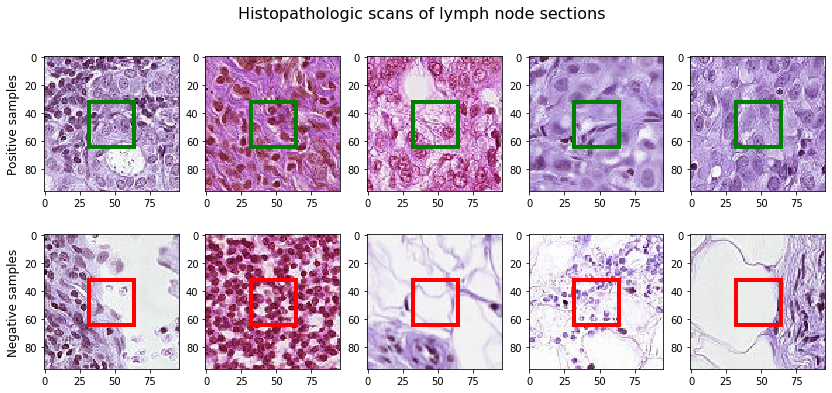

In [36]:
fig, ax = plt.subplots(2, 5, figsize=(14, 6))
fig.suptitle('Histopathologic scans of lymph node sections', fontsize=16)

np.random.shuffle(X_positive)
for i in range(5):
    ax[0, i].imshow(X_positive[i, :, :, :])
    rect = patches.Rectangle((32, 32), 32, 32, edgecolor='g', facecolor='none', linewidth=4)
    ax[0, i].add_patch(rect)
ax[0, 0].set_ylabel('Positive samples', size='large')

np.random.shuffle(X_negative)
for i in range(5):
    ax[1, i].imshow(X_negative[i, :, :, :])
    rect = patches.Rectangle((32, 32), 32, 32, edgecolor='r', facecolor='none', linewidth=4)
    ax[1, i].add_patch(rect)
ax[1, 0].set_ylabel('Negative samples', size='large');

# Feature engineering

### Color channels

As mentioned before it is hard to describe useful features but let's do some feature engineering on each channel: red, green and blue. First let's take a look how looks the distribution of colors in each class.

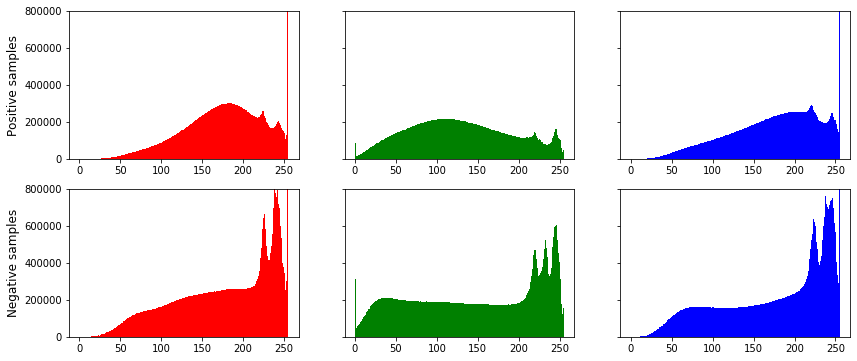

In [39]:
fig, ax = plt.subplots(2, 3, figsize=(14, 6), sharey=True)

colors=['r', 'g', 'b']
for i in range(3):
    ax[0, i].hist(X_positive[:, :, :, i].flatten(), bins=256, color=colors[i])
    ax[1, i].hist(X_negative[:, :, :, i].flatten(), bins=256, color=colors[i])
ax[0, 0].set_ylim(top=800000)
ax[0, 0].set_ylabel('Positive samples', size='large')   
ax[1, 0].set_ylabel('Negative samples', size='large');

Now we can clearly spot the difference between classes. Positive samples usually have darker colors (remember: 0 is black, 255). The peaks of distributions from first row are on the lefthand side of peaks from second row. Interesting fact is that many white spots appear in both clasess. You can notice a very high value for 255 in blue channel. It might be an artefact which we may need to deal with later. To make sure that negative samples seems to consist of brighter colors than negative samples let's take a look on mean image brightness.

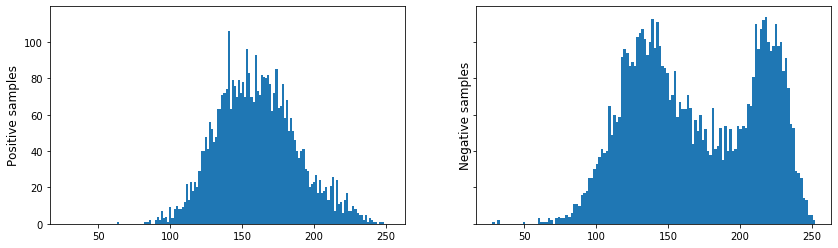

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(14,4), sharey=True, sharex = True)

ax[0].hist(np.mean(X_positive,axis=(1,2,3)), bins=128);
ax[1].hist(np.mean(X_negative,axis=(1,2,3)), bins=128);
ax[0].set_ylabel('Positive samples', size='large')   
ax[1].set_ylabel('Negative samples', size='large');

Here we can also see that distribution of mean brightness for positive samples tends to be unimodal with the peak around 160. Whereas for negative samples, it seems to behave like bimodal distribution with peaks in 140 and 220.

# k-Nearest Neighbours

At very beginning let's check very naive algorithm - kNN. Beacause the data set is large and because of RAM limitation we will use on 20k frist images and split them in ratio 80:20.

In [81]:
def KNN(train_X, train_Y, test_X, ks, verbose=False):
    preds = {}
    probs_pos = {}
    probs_neg = {}

    dists = np.sqrt(np.sum(train_X**2, axis=1).reshape(-1, 1) + 
            np.sum(test_X**2, axis=1).reshape(1, -1) - 
            2*train_X.dot(test_X.T))

    closest = np.argsort(dists, axis=0)

    targets = train_Y[closest]

    for k in ks:
        predictions = sstats.mode(targets[:k])[0]
        predictions = predictions.ravel()        
        preds[k] = predictions
        probs_pos[k] = np.sum(targets[:k], axis=0) / k
        probs_neg[k] = 1 - np.sum(targets[:k], axis=0) / k
    return preds, probs_pos, probs_neg

In [82]:
def batched_KNN(train_X, train_Y, test_X, ks, batch_size=50):
    iterations = split_idx // batch_size
    all_preds = {k: [] for k in ks}
    all_probs_pos = {k: [] for k in ks}
    all_probs_neg = {k: [] for k in ks}
    with trange(iterations) as t:
        for i in t:
            start_idx = i * batch_size
            batch_X = test_X[start_idx : start_idx + batch_size]
            batch_preds, batch_probs_pos, batch_probs_neg = KNN(train_X, train_Y, batch_X, ks)
            for k in all_preds.keys():
                all_preds[k] = np.concatenate((all_preds[k], batch_preds[k]))
                all_probs_pos[k] = np.concatenate((all_probs_pos[k], batch_probs_pos[k]))
                all_probs_neg[k] = np.concatenate((all_probs_neg[k], batch_probs_neg[k]))
            t.set_description('Running KNN')
    return all_preds, all_probs_pos, all_probs_neg

In [98]:
X = load_n_images(20000, data)
y = np.squeeze(data['label'].values)[:20000]
X_knn = X.reshape(-1, 48 * 48 * 3)
split_idx = int(0.8 * len(y))

In [99]:
ks = [1, 3, 5, 7, 11]

preds, probs_pos, probs_neg = batched_KNN(X_knn[:split_idx, :], y[:split_idx], X_knn[split_idx:, :], ks)

Running KNN: 100%|██████████| 320/320 [06:01<00:00,  1.13s/it]


Now we can plot ROC curves for each for each k to see the quality of classifiers.

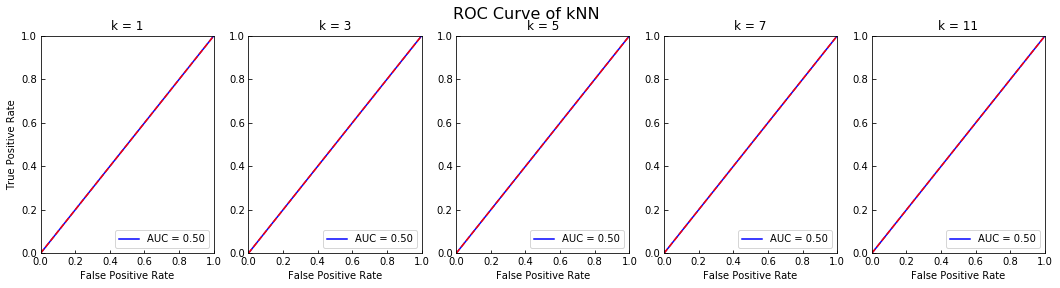

In [119]:
fig, ax = plt.subplots(1, 5, figsize=(18,4))
fig.suptitle('ROC Curve of kNN', fontsize=16)

for i in range(5):
    fpr, tpr, threshold = roc_curve(y[split_idx:], probs_pos[3])
    roc_auc = auc(fpr, tpr)

    ax[i].plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    ax[i].legend(loc = 'lower right')
    ax[i].plot([0, 1], [0, 1],'r--')
    ax[i].set_title('k = %d' % ks[i])
    ax[i].set_xlabel('False Positive Rate')
    ax[i].set_xlim([0, 1])
    ax[i].set_ylim([0, 1])
    ax[i].tick_params(axis="y",direction="in")
    ax[i].tick_params(axis="x",direction="in")

ax[0].set_ylabel('True Positive Rate')
    
plt.show()

### Conclusions

The result is not unexpected. The space is huge so kNN cannot fit correctly and works like random classfier.

# Convolutional Neural Net

### Model description

The model for this problem will be convolutional neural net using ReLU as activation function with batch normalization, max pooling and dropouts. Below you can find an architecture of the net.

- Convolution layer ({32, 64, 128} filters, 3 x 3 kernel)
- Batch normalization layer
- Activation layer (ReLU)
- Convolution layer ({32, 64, 128} filters, 3 x 3 kernel)
- Batch normalization layer
- Activation layer (ReLU)
- Max pooling layer (2 x 2)
- Dropout layer

This block is repeated three times with size of filters given in curly brackets. At the end  an output will be flatten and full connected to 256 neurons and finally converted to values from 0 to 1 using sigmoid.

- Flatten layer
- Fully conected layer (256)
- Batch normalization layer
- Activation layer (ReLU)
- Dropout layer
- Fully conected layer (1) with sigmoid

In [7]:
def build_model():
    filters_size = [32, 64, 128]

    nn = Sequential()

    for filter_size in filters_size:
        if filter_size == 32:
            nn.add(Conv2D(filter_size, 3, input_shape = (48, 48, 3)))
        else:
            nn.add(Conv2D(filter_size, 3, use_bias=False))
        nn.add(BatchNormalization())
        nn.add(Activation("relu"))
        nn.add(Conv2D(filter_size, 3, use_bias=False))
        nn.add(BatchNormalization())
        nn.add(Activation("relu"))
        nn.add(MaxPool2D(pool_size=2)) 
        nn.add(Dropout(0.3))

    nn.add(Flatten())
    nn.add(Dense(256, use_bias=False))
    nn.add(BatchNormalization())
    nn.add(Activation("relu"))
    nn.add(Dropout(0.5))

    nn.add(Dense(1, activation = "sigmoid"))
    return nn

### Compilation and data loading 

Now we can compile model with Adam optimizer and binary crossentropy as loss function. This time we use full dataset. We will again split the data using 80% for training and 20% to validation. 

In [123]:
nn = build_model()
nn.compile(loss=binary_crossentropy, optimizer=Adam(0.001), metrics=['accuracy'])

In [121]:
X = load_n_images(len(data), data)
y = np.squeeze(data['label'].values)
split_idx = int(0.8 * len(y))

### Training

We decided to set batch size on 50 which means that the newtork will process 50 images at ones. Reshuffling the data between the epochs can improve the outcome but for now we skip it. The problem is RAM and it seems that reshuffling should be made in-place somehow. But this issue require further investigation.

In [124]:
batch_size = 50

for epoch in range(5):
    
    iterations = split_idx // batch_size
    loss, acc = 0, 0
    with trange(iterations) as t:
        for i in t:
            start_idx = i * batch_size
            x_batch = X[start_idx : start_idx + batch_size]
            y_batch = y[start_idx : start_idx + batch_size]

            metrics = nn.train_on_batch(x_batch, y_batch)

            loss = loss + metrics[0]
            acc = acc + metrics[1]
            t.set_description('Running training epoch ' + str(epoch))
            t.set_postfix(loss="%.2f" % round(loss / (i + 1), 2), acc="%.2f" % round(acc / (i + 1), 2))

Running training epoch 4: 100%|██████████| 3520/3520 [31:34<00:00,  1.86it/s, acc=0.86, loss=0.33]


### Validation

Now we can verify the model on remaining 20% of dataset. As it was with kNN we extract not only accuracy and loss but also probabilities of assiging a sample to each class. This allows to build a ROC curve and calculate the area under it.

In [163]:
iterations = (len(y) - split_idx) // batch_size
loss, acc = 0, 0
all_preds = np.array([])
with trange(iterations) as t:
    for i in t:
        start_idx = i * batch_size
        x_batch = X[split_idx + start_idx : split_idx + start_idx + batch_size]
        y_batch = y[split_idx + start_idx : split_idx + start_idx + batch_size]
        
        metrics = nn.test_on_batch(x_batch, y_batch)
        preds = nn.predict_classes(x_batch)
        all_preds = np.concatenate((all_preds, preds.ravel()))
        
        loss = loss + metrics[0]
        acc = acc + metrics[1]
        t.set_description('Running validation')
        t.set_postfix(loss="%.2f" % round(loss / (i + 1), 2), acc="%.2f" % round(acc / (i + 1), 2))
        
print("Validation loss:", loss / iterations)
print("Validation accuracy:", acc / iterations)

Running validation: 100%|██████████| 880/880 [05:01<00:00,  2.91it/s, acc=0.84, loss=0.37]

Validation loss: 0.37106024204668675
Validation accuracy: 0.837613629820672


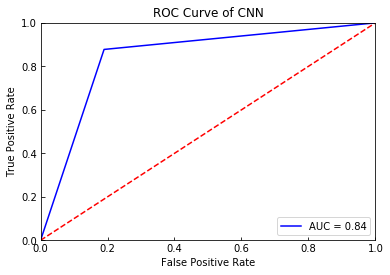

In [164]:
fpr, tpr, threshold = roc_curve(y[split_idx:-5], all_preds)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC Curve of CNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tick_params(axis="y",direction="in")
plt.tick_params(axis="x",direction="in")

    
plt.show()

# Neural Architecture Search

### What is NAS?

Neural Architecture Search (NAS) is the process of automating architecture engineering i.e. finding the design of our machine learning model. Where we need to provide a NAS system with a dataset and a task (classification, regression, etc), and it will give us the architecture. And this architecture will perform best among all other architecture for that given task when trained by the dataset provided. NAS can be seen as a subfield of AutoML and has a significant overlap with hyperparameter optimization. To understand NAS we need to look deeply into what it is doing. It finds an architecture from all possible architectures by following a search strategy that will maximize the performance. The following figure summarizes the NAS algorithm.


(source: https://towardsdatascience.com/neural-architecture-search-nas-the-future-of-deep-learning-c99356351136)

![title](nas.png)

Search space defines what neural architecture a NAS approach might discover in principle. The search strategy and performance estimation can be solved with RL. Reinforcement learning is the problem faced by an agent that must learn behavior through trial and error interactions with a dynamic environment to maximize some reward. In the case of NAS, the agent produces the model architecture. Then the model is trained on the dataset and the performance of the model on the validation data is taken as a reward.

### Data generator

Firstly we need to prepare our data. This we also use data aumgmentation. Nothing fancy, but random flips and rotations should be enough for the beginning. (Unimplemented now). Again we will take only 48 x 48px center region of images.

In [84]:
class data_generator:
    
    def create_train(dataset_info, batch_size, augument=False, shuffle=False):
        while True:
            if shuffle:
                dataset_info = dataset_info.sample(frac=1).reset_index(drop=True)
            else:
                dataset_info = dataset_info.reset_index(drop=True)
            for start in range(0, len(dataset_info), batch_size):
                end = min(start + batch_size, len(dataset_info))
                batch_images = []
                X_train_batch = dataset_info.loc[start : end].reset_index(drop=True)
                batch_labels = np.zeros(len(X_train_batch))
                for i in range(len(X_train_batch)):
                    image = data_generator.load_image(X_train_batch['path'][i])   
                    if augument:
                        image = augment(image) 
                    batch_images.append(image)
                    batch_labels[i] = dataset_info['label'][start + i]
                yield np.array(batch_images), batch_labels

    def load_image(path):
        croppped = np.zeros([48, 48, 3], dtype=np.uint8)
        photo = cv2.imread(path)
        cropped = photo[24 : 24 + 48, 24 : 24 + 48, :]
        return cropped

    def augment(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)

        image_aug = augment_img.augment_image(image)
        return image_aug

When data generator is ready we can the dataset using 80% for training and 20% to validation. 

In [85]:
indexes = np.arange(len(data))
np.random.shuffle(indexes)
train_idxs, valid_idxs = train_test_split(indexes, test_size=0.2, random_state=42)

batch_size = 200
train_generator = data_generator.create_train(data.loc[train_idxs], batch_size, augument=False, shuffle=True)
validation_generator = data_generator.create_train(data.loc[valid_idxs], batch_size, augument=False)

### Model describtion

So let's build a NASNet using keras and try to beat earlier proposed architecture. We will use builtin NASNetMoble. The output will be passed through GlobalAveragePooling to fully conected layer with sigmoid used as an activation function.

In [74]:
def create_nas_model():
    input_tensor = Input(shape=(48, 48, 3))
    base_model = NASNetMobile(include_top=False, input_tensor=input_tensor)
    bn = BatchNormalization()(input_tensor)
    out = base_model(bn)
    out = GlobalAveragePooling2D()(out)
    out = Dropout(0.5)(out)
    out = Dense(1, activation='sigmoid')(out)    
    model = Model(input_tensor, out)
    
    return model

### Compilation

Again we will use Adam as optimizer and binary cross entropy as a loss function.

In [86]:
checkpoint = ModelCheckpoint('NASNet.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
callbacks_list = [checkpoint]

In [87]:
model = build_model()
model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

### Training

In [88]:
H = model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(float(len(train_idxs)) / float(batch_size)),
    validation_data=validation_generator,
    validation_steps=np.ceil(float(len(valid_idxs)) / float(batch_size)),
    epochs=3, 
    verbose=1,
    callbacks=callbacks_list)

Epoch 1/3
881/881 [==============================] - 2372s 3s/step - loss: 0.4374 - accuracy: 0.8081 - val_loss: 1.3392 - val_accuracy: 0.7434

Epoch 00001: val_loss improved from inf to 1.33921, saving model to NASNet.h5
Epoch 2/3
 40/881 [>.............................] - ETA: 30:15 - loss: 0.3938 - accuracy: 0.8315

KeyboardInterrupt: 

### Validation

This time we use load the best model. Model Checkpoint was added to save the best model after each epoch. We trained the model several times so now use the best one.

In [92]:
def load_trained_model(weights_path):
    model = build_model()
    model.load_weights(weights_path)
    return model

In [93]:
model = load_trained_model('NASNet.h5')

In [94]:
valid_steps = len(valid_idxs) / batch_size

probs = model.predict_generator(validation_generator, steps=valid_steps, verbose=1)

221/220 [==============================] - 154s 698ms/step


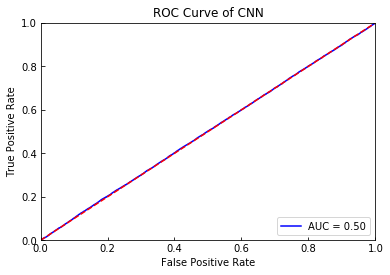

In [98]:
y = np.squeeze(data['label'].values)
fpr, tpr, threshold = roc_curve(y[valid_idxs], probs[:len(valid_idxs)].ravel())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC Curve of CNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tick_params(axis="y",direction="in")
plt.tick_params(axis="x",direction="in")

    
plt.show()

# Next steps

- Better data augementation
- Shuffle data between epochs
- Train and validate NASNet on full dataset
- Check classic net, e.g. ResNet, or other classic algorithm
- Dataset reduction: maybe it is a good idea to remove very bright samples because the appear in both classes
- Cross validation for CNN and NASNet